# Gaining Perspective on Stock Prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import *

In [2]:
slb = pd.read_csv('.\\slb_stock.csv', parse_dates=['Date'])

criteria = (datetime.today() - slb['Date']).astype(datetime).map(lambda x: np.nan if pd.isnull(x) else x.days) <= 4*365
slb = slb[criteria]
slb.head()

,Code,Date,Open,High,Low,Close,Volume
2787205,1PG,2014-11-20,0.605,0.620,0.550,0.565,1191129
2787206,3PL,2014-11-20,2.400,2.410,2.340,2.380,822983
2787207,8CO,2014-11-20,0.230,0.230,0.230,0.230,3000
2787208,AAA,2014-11-20,50.160,50.170,50.140,50.160,29993
2787209,AAC,2014-11-20,1.500,1.507,1.485,1.495,584394


In [3]:
slb_info = slb.groupby(['Code'])['Close'].describe(percentiles=[.1, .2, .5, .9])
slb_info.head()

,count,mean,std,min,10%,20%,50%,90%,max
Code,,,,,,,,,
14D,48.0,0.311667,0.041222,0.225,0.2755,0.285,0.300,0.370,0.435
1AD,337.0,0.265021,0.048622,0.170,0.2100,0.220,0.260,0.340,0.390
1AG,501.0,0.045238,0.017789,0.021,0.0300,0.032,0.042,0.064,0.135
1AL,274.0,0.963814,0.039139,0.800,0.9015,0.935,0.975,1.000,1.070
1PG,578.0,1.607189,1.420123,0.155,0.1850,0.247,1.180,4.160,5.440


In [4]:
slb_last = slb.groupby(['Code'])['Date'].max()
slb_last_price = pd.merge(slb_last.to_frame(), slb, on=['Code', 'Date'])
slb_last_price.head()

,Code,Date,Open,High,Low,Close,Volume
0,14D,2018-11-16,0.265,0.280,0.265,0.280,153229
1,1AD,2018-11-09,0.305,0.305,0.305,0.305,16344
2,1AG,2018-11-14,0.046,0.048,0.046,0.046,489490
3,1AL,2018-09-28,0.975,0.975,0.975,0.975,5000
4,1PG,2017-03-08,0.165,0.165,0.165,0.165,100015


In [5]:
slb_merged = pd.merge(slb_info, slb_last_price, on='Code')

slb_close_all = slb_merged.set_index('Code')

slb_close_all.loc[slb_close_all['Close'] < slb_close_all['10%'], 'Perspective'] = 'Low10%'
slb_close_all.loc[(slb_close_all['Close'] >= slb_close_all['10%']) & 
                  (slb_close_all['Close'] < slb_close_all['20%']), 'Perspective'] = 'Low20%'
slb_close_all['Perspective%'] = ((1 - (slb_close_all['Close'] - slb_close_all['min']) / slb_close_all['Close']) * 100).astype(int)

slb_close_all.head()

,count,mean,std,min,10%,20%,50%,90%,max,Date,Open,High,Low,Close,Volume,Perspective,Perspective%
Code,,,,,,,,,,,,,,,,,
14D,48.0,0.311667,0.041222,0.225,0.2755,0.285,0.300,0.370,0.435,2018-11-16,0.265,0.280,0.265,0.280,153229,Low20%,80
1AD,337.0,0.265021,0.048622,0.170,0.2100,0.220,0.260,0.340,0.390,2018-11-09,0.305,0.305,0.305,0.305,16344,NaN,55
1AG,501.0,0.045238,0.017789,0.021,0.0300,0.032,0.042,0.064,0.135,2018-11-14,0.046,0.048,0.046,0.046,489490,NaN,45
1AL,274.0,0.963814,0.039139,0.800,0.9015,0.935,0.975,1.000,1.070,2018-09-28,0.975,0.975,0.975,0.975,5000,NaN,82
1PG,578.0,1.607189,1.420123,0.155,0.1850,0.247,1.180,4.160,5.440,2017-03-08,0.165,0.165,0.165,0.165,100015,Low10%,93


In [6]:
slb_selected = pd.read_csv('.\\asx200.csv', index_col='Code')

slb_close = pd.merge(slb_selected, slb_close_all, on='Code')
slb_close = slb_close.sort_values(['Perspective', 'Perspective%'], ascending=[False, False])

cols = ['Company', 'Sector', 'min', 'max', 'mean', '10%', '20%', 'Perspective', 'Perspective%', 'Close']
criteria = slb_close['Perspective'].isin(['Low10%'])
slb_close.loc[criteria,cols].head(20)

,Company,Sector,min,max,mean,10%,20%,Perspective,Perspective%,Close
Code,,,,,,,,,,
AOG,Aveo Group Ordinary/Units FP Stapled Securities,Real Estate,1.620,3.640,2.801371,2.280,2.430,Low10%,100,1.620
NAB,National Aust. Bank,Financials,23.770,39.570,30.011122,26.312,27.364,Low10%,100,23.770
URW,Unibailrodawestfield Chess Depositary Interest...,Real Estate,12.310,15.100,14.110909,12.690,13.030,Low10%,100,12.310
VEA,Viva Energy Group,Energy,2.050,2.510,2.299231,2.090,2.140,Low10%,100,2.050
WBC,Westpac Banking Corp,Financials,25.270,39.890,31.467968,28.628,29.590,Low10%,100,25.270
AAD,Ardent Leisure Group Ordinary/Units FP Stapled...,Consumer Discretionary,1.555,3.050,2.136597,1.760,1.880,Low10%,99,1.565
AHG,Automotive Holdings,Consumer Discretionary,1.745,4.970,3.682461,2.668,3.320,Low10%,99,1.760
CTX,Caltex Australia,Energy,26.850,38.750,32.494985,29.500,30.460,Low10%,99,26.890
DHG,Domain Holdings Aus,Information Technology,2.330,3.690,3.198543,2.756,3.050,Low10%,99,2.350


In [7]:
criteria = slb_close['Perspective'].isin(['Low20%'])
slb_close.loc[criteria,cols].head(20)

,Company,Sector,min,max,mean,10%,20%,Perspective,Perspective%,Close
Code,,,,,,,,,,
PDL,Pendal Group Limited,Financials,7.73,10.37,9.169214,8.200,8.484,Low20%,94,8.20
GNC,Graincorp Limited Class A,Consumer Staples,7.21,10.48,8.530262,7.720,7.950,Low20%,93,7.75
AMC,Amcor Limited,Materials,11.92,16.70,14.426634,13.160,13.540,Low20%,88,13.50
ANZ,ANZ Banking Group Limited,Financials,22.18,37.19,28.780257,24.946,26.540,Low20%,87,25.36
PTM,Platinum Asset,Financials,4.25,9.30,6.318675,4.980,5.190,Low20%,84,5.03
CSR,CSR Limited,Materials,2.42,5.74,3.984026,3.050,3.410,Low20%,79,3.05
BEN,Bendigo and Adelaide,Financials,8.05,14.38,11.235104,9.840,10.300,Low20%,78,10.20
JHX,James Hardie Indust Chess Depositary Interests...,Materials,11.77,23.98,19.154787,15.220,17.090,Low20%,72,16.29
GEM,G8 Education Limited,Consumer Discretionary,1.91,4.79,3.409020,2.420,2.970,Low20%,67,2.84


# ===============================

In [19]:
selected_stock = 'CWN'

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+selected_stock+'.AX&outputsize=full&apikey=5ED1VS8NM0IGMZPA&datatype=csv'
slb = pd.read_csv(url, parse_dates=['timestamp'])

criteria = (datetime.today() - slb['timestamp']).astype(datetime).map(lambda x: np.nan if pd.isnull(x) else x.days) <= 1*365
slb = slb[criteria]

slb['Code'] = selected_stock
col_order = ['Code', 'timestamp', 'open', 'high', 'low', 'close', 'volume']
col_rename = {'timestamp':'Date', 'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}

slb_stock = slb[col_order].rename(columns=col_rename)
slb_stock.head()

,Code,Date,Open,High,Low,Close,Volume
0,CWN,2018-11-16,11.80,11.83,11.690,11.77,1174570
1,CWN,2018-11-13,11.59,11.76,11.550,11.63,1903049
2,CWN,2018-11-12,11.66,11.70,11.530,11.62,2804914
3,CWN,2018-11-11,11.77,11.90,11.730,11.87,1247444
4,CWN,2018-11-08,11.86,11.92,11.715,11.77,1156692


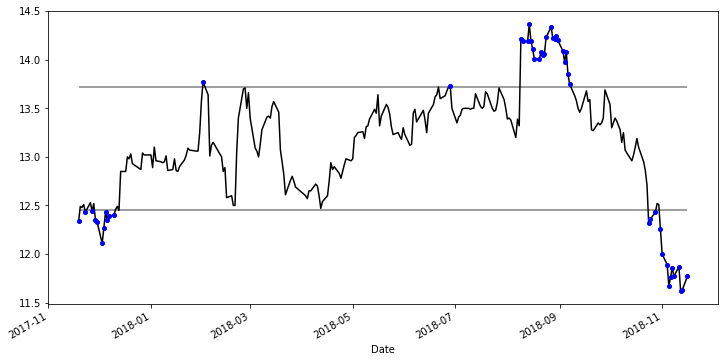

In [20]:
slb_stock = slb_stock.set_index('Date')

slb_stock_close = slb_stock['Close']
slb_stock_summary = slb_stock_close.describe(percentiles=[.1, .9])

upper_10 = slb_stock_summary.loc['90%']
lower_10 = slb_stock_summary.loc['10%']
criteria = (slb_stock_close < lower_10) | (slb_stock_close > upper_10)
slb_stock_top_bottom_10 = slb_stock_close[criteria]

slb_stock_close.plot(color='black', figsize=(12,6))
slb_stock_top_bottom_10.plot(marker='o', style=' ', ms=4, color='blue')

xmin = criteria.index[0]
xmax = criteria.index[-1]
plt.hlines(y=[lower_10, upper_10], xmin=xmin, xmax=xmax, color='gray')

In [21]:
lower_10, upper_10

(12.45, 13.72)

# ===============================

In [22]:
# Initialize the short and long windows
short_window = 30
long_window = 60

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=slb_stock.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = slb_stock['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = slb_stock['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0) 

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal  short_mavg  long_mavg  positions
Date                                                
2018-11-16     0.0   11.770000  11.770000        NaN
2018-11-13     0.0   11.700000  11.700000        0.0
2018-11-12     0.0   11.673333  11.673333        0.0
2018-11-11     0.0   11.722500  11.722500        0.0
2018-11-08     0.0   11.732000  11.732000        0.0
2018-11-07     0.0   11.753333  11.753333        0.0
2018-11-06     0.0   11.754286  11.754286        0.0
2018-11-05     0.0   11.743750  11.743750        0.0
2018-11-04     0.0   11.760000  11.760000        0.0
2018-11-01     0.0   11.784000  11.784000        0.0
2018-10-31     0.0   11.827273  11.827273        0.0
2018-10-30     0.0   11.884167  11.884167        0.0
2018-10-29     0.0   11.933077  11.933077        0.0
2018-10-28     0.0   11.968571  11.968571        0.0
2018-10-25     0.0   11.994667  11.994667        0.0
2018-10-24     0.0   12.015000  12.015000        0.0
2018-10-23     0.0   12.055882  12.055882     

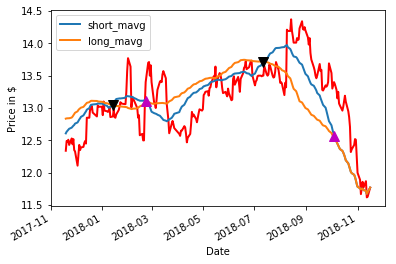

In [23]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
slb_stock['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [24]:
signals[signals['positions'] == 1.00]

,signal,short_mavg,long_mavg,positions
Date,,,,
2018-10-04,1.0,12.564000,12.538387,1.0
2018-02-22,1.0,13.111667,13.094667,1.0


In [25]:
signals[signals['positions'] == -1.00]

,signal,short_mavg,long_mavg,positions
Date,,,,
2018-07-12,0.0,13.710333,13.715667,-1.0
2018-01-14,0.0,13.048667,13.050167,-1.0


In [26]:
slb_stock.tail()

,Code,Open,High,Low,Close,Volume
Date,,,,,,
2017-11-23,CWN,12.40,12.440,12.28,12.43,1798308
2017-11-22,CWN,12.47,12.540,12.38,12.51,1389066
2017-11-21,CWN,12.50,12.520,12.38,12.48,1193681
2017-11-20,CWN,12.37,12.600,12.34,12.49,1484897
2017-11-19,CWN,12.15,12.365,12.10,12.34,1419437


In [27]:
slb_stock.describe()

,Open,High,Low,Close,Volume
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,13.147928,13.261873,13.049841,13.151394,1.496657e+06
std,0.545283,0.547541,0.545153,0.545962,1.047728e+06
min,11.590000,11.700000,11.530000,11.620000,3.168470e+05
25%,12.885000,13.000000,12.800000,12.855000,9.523070e+05
50%,13.200000,13.310000,13.080000,13.200000,1.282932e+06
75%,13.510000,13.605000,13.427500,13.500000,1.727512e+06
max,14.370000,14.590000,14.220000,14.370000,1.022766e+07


In [28]:
# Set the initial capital
initial_capital= float(20000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions[selected_stock] = 4000*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(slb_stock['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(slb_stock['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(slb_stock['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

            CWN  holdings     cash    total  returns
Date                                                
2018-11-16  0.0       0.0  20000.0  20000.0      NaN
2018-11-13  0.0       0.0  20000.0  20000.0      0.0
2018-11-12  0.0       0.0  20000.0  20000.0      0.0
2018-11-11  0.0       0.0  20000.0  20000.0      0.0
2018-11-08  0.0       0.0  20000.0  20000.0      0.0


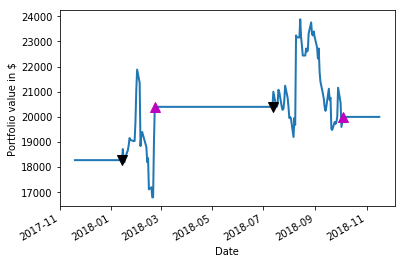

In [29]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()